## Research Question 2: What is the causal relationship between enforced seat belt regulations and fatilities per miles driven?

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Avoid false positive chain warnings
pd.options.mode.chained_assignment = None  # default='warn'
sns.set(rc = {'figure.figsize':(15,8)})

### NHTSA DATA

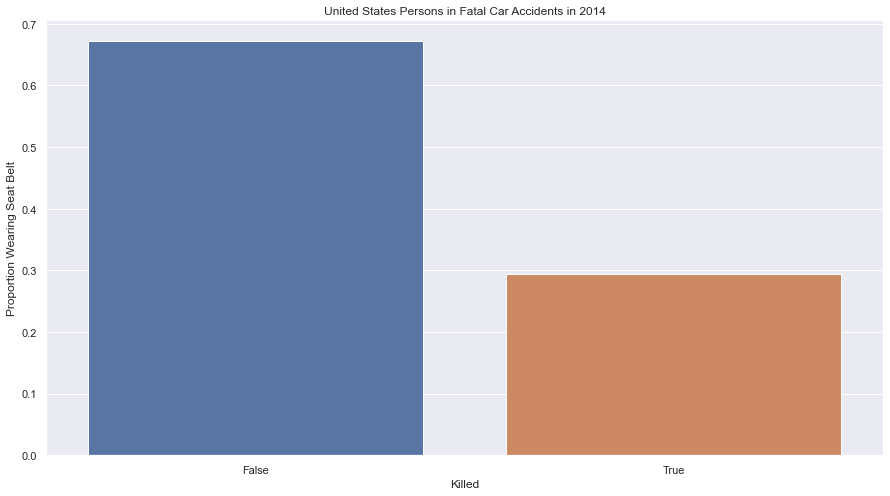

In [2]:
# Read in 2014 the NHTSA dataset for persons involved in accidents
# in which there was at least 1 fatality.
persons_2014 = pd.read_csv("FARS2014NationalCSV/PERSON.CSV", encoding = 'latin-1')
# Plot proportion of people who wore seat belts and died in fatal car accidents 
persons_2014["Killed"] = persons_2014["INJ_SEV"] == 4
persons_2014["Belt"] = persons_2014["REST_USE"] == 3
grouped_persons_2014 = persons_2014.groupby("Killed").agg("mean").reset_index()
p = sns.barplot(x="Killed", y = "Belt", data = grouped_persons_2014)
p.set(xlabel = "Killed", ylabel="Proportion Wearing Seat Belt", title="United States Persons in Fatal Car Accidents in 2014");

### BTS DATA

In [3]:
# Read in state transportation data.
state_transport_data = pd.read_csv("state_transport_data.csv", encoding = "utf-16", sep='\t')
# dictionary with year that each state adopted the primary seatbelt enforcement law.
# float('inf') if not currently adopted.
# Note that seatbelt laws were sometimes adopted within a specific year
# e.g. June 2013 (TODO account for this)
# https://www.cdc.gov/motorvehiclesafety/calculator/factsheet/seatbelt.html
year_adopted = {'Alabama': 1991, 'Alaska': 1990, 'Arizona': 1991, 'Arkansas': 2009, 'California': 1986,
       'Colorado': float('inf'), 'Connecticut': 1986, 'Delaware': 1997, 'District of Columbia': 2003,
       'Florida': 2009, 'Georgia': 1988, 'Hawaii': 1985, 'Idaho': float('inf'), 'Illinois': 2003, 'Indiana': 1998,
       'Iowa': 1986, 'Kansas': 2010, 'Kentucky': 2006, 'Louisiana': 1995, 'Maine': 2007, 'Maryland': 1997,
       'Massachusetts': float('inf'), 'Michigan': 2000, 'Minnesota': 2009, 'Mississippi': 2006,
       'Missouri': float('inf'), 'Montana': float('inf'), 'Nebraska': float('inf'), 'Nevada':float('inf'), 'New Hampshire':float('inf'),
       'New Jersey':2000, 'New Mexico':1986, 'New York':1984, 'North Carolina':2006,
       'North Dakota':float('inf'), 'Ohio':float('inf'), 'Oklahoma':1997, 'Oregon':1990, 'Pennsylvania':float('inf'),
       'Rhode Island':2011, 'South Carolina':2005, 'South Dakota':float('inf'), 'Tennessee':2004,
       'Texas': 1985, 'Utah':float('inf'), 'Vermont':float('inf'), 'Virginia':float('inf'),
       'Washington':2002, 'West Virginia':2013, 'Wisconsin':2009, 'Wyoming':float('inf')} # (TODO double-check these dates.)
state_transport_data.head(5)

,State,Measures,Year,Values
0,United States,Transit Ridership,2020,5.937573e+09
1,United States,Highway Fatalities,2020,3.906600e+04
2,United States,Highway use of gasoline (thousand gallons),2020,1.172510e+08
3,United States,Highway vehicle-miles traveled (millions),2020,2.917383e+06
4,United States,Vehicles,2020,2.759244e+08


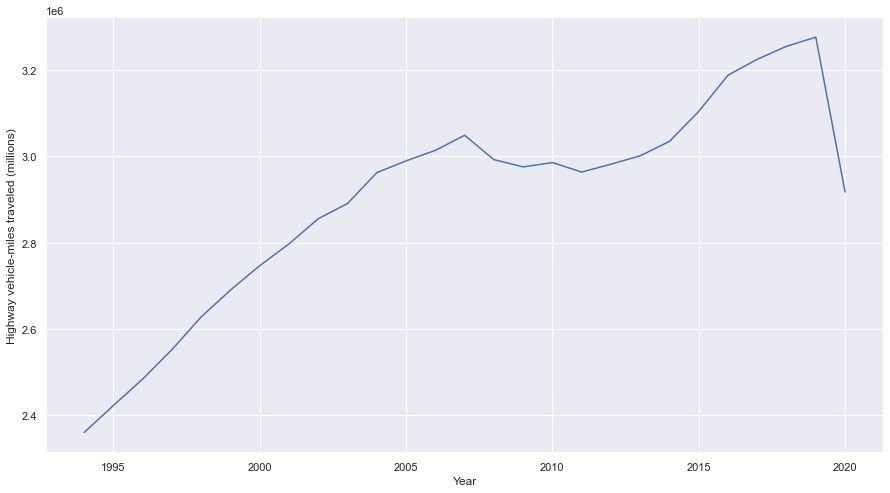

In [4]:
# Reformat data into columns using pivot table
df = pd.pivot_table(state_transport_data, index = ["State", "Year"], columns = "Measures", values="Values").reset_index()

# Visualize how highway miles traveled has changed over time
sns.lineplot(data = df[df["State"] == "United States"], x ="Year", y="Highway vehicle-miles traveled (millions)");

In [6]:
# Perform data cleaning
# -- Puerto Rico removed because it does not include fatalities data
# -- United states removed because it captures the rest of the data
# -- Years above 2019 removed because of COVID
# -- Years before 1994 removed because highway miles data
#    only goes as far back as 1994 (measurement differed in earlier years)
# -- Drop 'persons' columns with NaN entries in the given time period.
df_cleaned = df[(df["State"] != "Puerto Rico")&(df["State"] != "United States")&(df["Year"]<=2020)&(1994<=df["Year"])]
df_cleaned = df_cleaned.drop(["Person miles (millions)", "Person trips (millions)", "Persons traveling (thousands)"], axis = 1)

# Add treatment variable.
df_cleaned["year_adopted"] = df_cleaned["State"].apply(lambda x: year_adopted[x])
df_cleaned["adopted"] = df_cleaned["Year"] >= df_cleaned["year_adopted"]

# Add 'years since adoption' variable
# -- 0 before adoption, 1 in year of adoption, 2 in year after adoption etc.
year_difference = df_cleaned["Year"] - df_cleaned["year_adopted"] + 1
df_cleaned["years_since_adoption"] = np.maximum(year_difference, 0)

# More data cleaning
# -- Reduce set of states to those that had a transition during the given time period.
#    1994 - 2019 inclusive. (Avoid never-taker and always-taker states).
df_cleaned = df_cleaned[(df_cleaned["year_adopted"] > 1994)&(df_cleaned["year_adopted"]<2020)]
df_cleaned.head()

Measures,State,Year,Highway Fatalities,Highway use of gasoline (thousand gallons),Highway vehicle-miles traveled (millions),Licensed drivers,Transit Ridership,Vehicles,year_adopted,adopted,years_since_adoption
261,Arkansas,1994,609.0,1286100.0,24948.0,1768394.0,4535502.0,1566840.0,2009.0,False,0.0
262,Arkansas,1995,631.0,1318092.0,26653.0,1769012.0,4318941.0,1613200.0,2009.0,False,0.0
263,Arkansas,1996,615.0,1322962.0,27809.0,1752229.0,5457257.0,1626550.0,2009.0,False,0.0
264,Arkansas,1997,660.0,1368546.0,28076.0,1878618.0,5538620.0,1633830.0,2009.0,False,0.0
265,Arkansas,1998,625.0,1364348.0,28346.0,1918451.0,5324500.0,1754220.0,2009.0,False,0.0


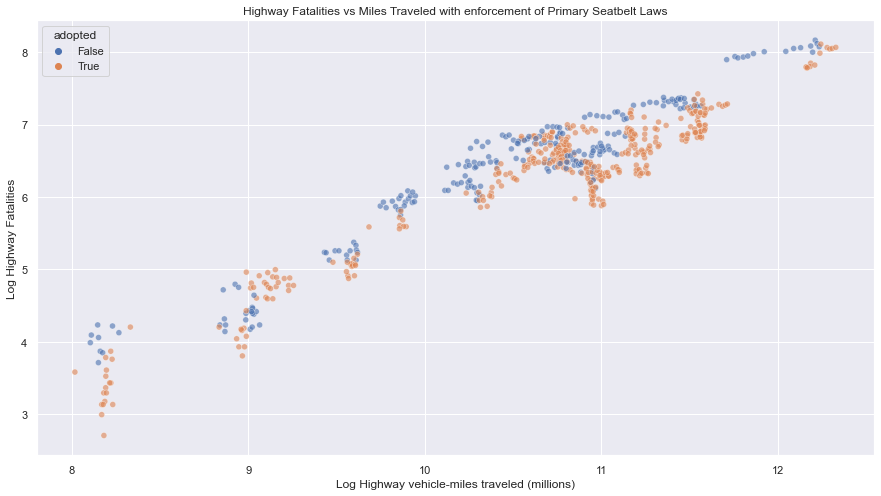

In [11]:
# Add log of highway fatalities and miles traveled;
# ratio of highway fatalities to miles traveled;
# and log ratio to dataset.
df_ratio = df_cleaned.copy()
df_ratio["Log Highway vehicle-miles traveled (millions)"] = np.log(df_cleaned["Highway vehicle-miles traveled (millions)"])
df_ratio["Log Highway Fatalities"] = np.log(df_cleaned["Highway Fatalities"])
df_ratio["Fatals/miles"] = df_ratio["Highway Fatalities"]/df_ratio["Highway vehicle-miles traveled (millions)"]
df_ratio["Log fatals/Log miles"] = df_ratio["Log Highway Fatalities"]/df_ratio["Log Highway vehicle-miles traveled (millions)"]

# Visualize highway fatalities vs miles traveled
p = sns.scatterplot(data = df_ratio, x = "Log Highway vehicle-miles traveled (millions)", y = "Log Highway Fatalities", hue="adopted", alpha = 0.6)
p.set(title="Highway Fatalities vs Miles Traveled with enforcement of Primary Seatbelt Laws");

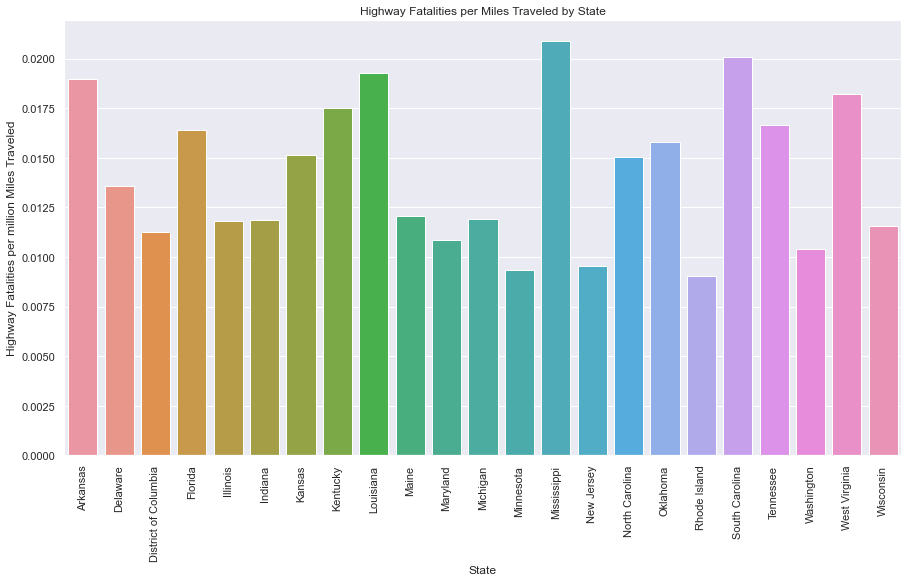

In [8]:
# Visualize mean highway fatalities per miles traveled in different states
df_means = df_ratio.loc[:,["State", "Fatals/miles", "Log fatals/Log miles"]].groupby("State").agg("mean").reset_index()
p = sns.barplot(data = df_means, x = "State", y = "Fatals/miles")
p.set_xticklabels(p.get_xticklabels(),rotation = 90)
p.set(title="Highway Fatalities per Miles Traveled by State", ylabel = "Highway Fatalities per million Miles Traveled");

### MIT Election Data

In [63]:
# https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/42MVDX
presidents = pd.read_csv("1976-2020-president.csv")

# Filter data for relevant time period 1994-2019 inclusive.
# Need data from 1992 election to fill 1992-1996 range.
presidents = presidents[(presidents["year"] <= 2019)&(1992 <= presidents["year"])]

# Calculate proportion of votes cast for each candidate
presidents["prop"] = presidents["candidatevotes"]/presidents["totalvotes"]

# Reformat data into columns using pivot table.
presidents = presidents.loc[:, ["year", "state", "prop", "party_simplified"]]
presidents = pd.pivot_table(presidents, index = ["state", "year"], columns = "party_simplified", values="prop").reset_index()

# Drop excess columns.
# -- Other can be captured by other columns. Libertarian sometimes NaN.
presidents = presidents.drop(["LIBERTARIAN", "OTHER"], axis = 1)
presidents.head()

party_simplified,state,year,DEMOCRAT,REPUBLICAN
0,ALABAMA,1992,0.408801,0.476454
1,ALABAMA,1996,0.431561,0.501218
2,ALABAMA,2000,0.415665,0.564838
3,ALABAMA,2004,0.368444,0.624607
4,ALABAMA,2008,0.387404,0.603169


### Data Merging and Pre-Processing

In [71]:
# Create df to expand president dataframe to include non-election years
election_years = np.array([[year]*4 for year in presidents["year"].unique()]).flatten()
years = np.array([[year, year + 1, year + 2, year + 3] for year in presidents["year"].unique()]).flatten()
all_years = pd.DataFrame({"year":election_years, "expanded_year":years})

# Election data with non-election years.
presidents_years = presidents.merge(all_years, on = "year")
presidents_years = presidents_years.drop("year", axis =1)

# Convert data and columns to appropriate format for join.
df_ratio["State"] = df_ratio["State"].apply(str.lower)
presidents_years["state"] = presidents_years["state"].apply(str.lower)
presidents_years = presidents_years.rename(columns = {"state":"State", "expanded_year":"Year"})

# Join dataframes.
df_joined = df_ratio.merge(presidents_years, how="inner", on = ["State", "Year"])
df_joined.head()

,State,Year,Highway Fatalities,Highway use of gasoline (thousand gallons),Highway vehicle-miles traveled (millions),Licensed drivers,Transit Ridership,Vehicles,year_adopted,adopted,years_since_adoption,Log Highway vehicle-miles traveled (millions),Log Highway Fatalities,Fatals/miles,Log fatals/Log miles,DEMOCRAT,REPUBLICAN
0,arkansas,1994,609.0,1286100.0,24948.0,1768394.0,4535502.0,1566840.0,2009.0,False,0.0,10.124549,6.411818,0.024411,0.633294,0.532080,0.354834
1,arkansas,1995,631.0,1318092.0,26653.0,1769012.0,4318941.0,1613200.0,2009.0,False,0.0,10.190657,6.447306,0.023675,0.632668,0.532080,0.354834
2,arkansas,1996,615.0,1322962.0,27809.0,1752229.0,5457257.0,1626550.0,2009.0,False,0.0,10.233115,6.421622,0.022115,0.627533,0.537364,0.368009
3,arkansas,1997,660.0,1368546.0,28076.0,1878618.0,5538620.0,1633830.0,2009.0,False,0.0,10.242670,6.492240,0.023508,0.633843,0.537364,0.368009
4,arkansas,1998,625.0,1364348.0,28346.0,1918451.0,5324500.0,1754220.0,2009.0,False,0.0,10.252241,6.437752,0.022049,0.627936,0.537364,0.368009


In [102]:
# One-hot encoding
from sklearn.preprocessing import OneHotEncoder
def ohe_column(data, name):
    """
    One-hot-encodes elements in the column named NAME. New columns are of the form NAME_ENTRY.
    """
    enc = OneHotEncoder(sparse=False, drop = "first") # TODO is it necessary to drop the column?
    enc.fit(data[[name]])
    df = pd.DataFrame(enc.transform(data[[name]]), columns = enc.get_feature_names_out(), index = data.index)
    return data.join(df)

# Use one hot encoding for categorical variables State and Years
# and create variable to track column names for confounders
df_ohe = ohe_column(df_joined, "Year")
df_ohe = ohe_column(df_ohe, "State")

# Remove repeated data.
excess_cols = ["Highway vehicle-miles traveled (millions)",
               "Log Highway Fatalities","Log Highway vehicle-miles traveled (millions)",
               "Highway Fatalities", "State", "Year", "year_adopted"]
df_ohe = df_ohe.drop(excess_cols, axis = 1)
df_ohe.head()

,Highway use of gasoline (thousand gallons),Licensed drivers,Transit Ridership,Vehicles,adopted,years_since_adoption,Fatals/miles,Log fatals/Log miles,DEMOCRAT,REPUBLICAN,...,State_mississippi,State_new jersey,State_north carolina,State_oklahoma,State_rhode island,State_south carolina,State_tennessee,State_washington,State_west virginia,State_wisconsin
0,1286100.0,1768394.0,4535502.0,1566840.0,False,0.0,0.024411,0.633294,0.532080,0.354834,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1318092.0,1769012.0,4318941.0,1613200.0,False,0.0,0.023675,0.632668,0.532080,0.354834,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1322962.0,1752229.0,5457257.0,1626550.0,False,0.0,0.022115,0.627533,0.537364,0.368009,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1368546.0,1878618.0,5538620.0,1633830.0,False,0.0,0.023508,0.633843,0.537364,0.368009,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1364348.0,1918451.0,5324500.0,1754220.0,False,0.0,0.022049,0.627936,0.537364,0.368009,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
# Deal with null entries (This method simply removes rows with any null entries.)
### TODO FIX THIS !!!!!
df_ohe = df_ohe.drop(df_ohe[df_ohe.isnull().values == True].index).reset_index()
df_ohe.isnull().values.any()

False

### Propensity Score Calculation

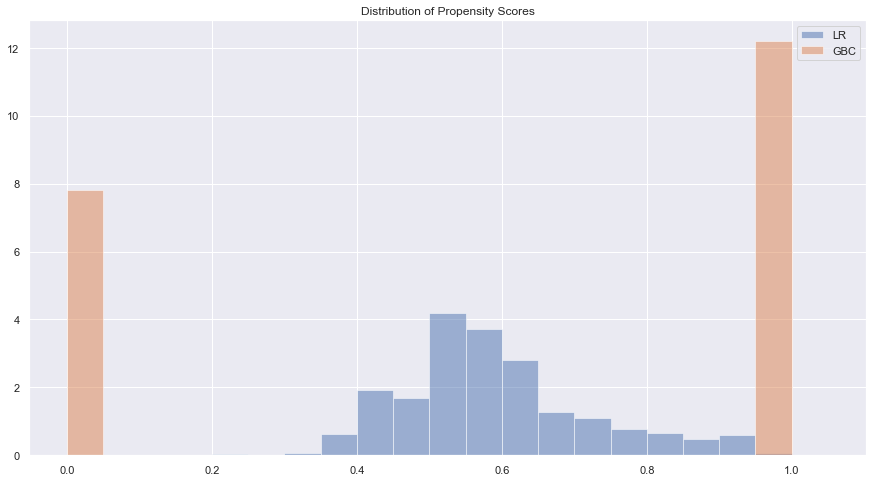

In [150]:
confounders = df_ohe.columns.drop(["level_0", "index", "Log fatals/Log miles", "Fatals/miles", "adopted"])
treatment = "adopted"
outcome = "Fatals/miles"
# outcome = "Log fatals/Log miles" #TODO choose appropriate approach

X = df_ohe.loc[:, confounders]
Z = df_ohe.loc[:, treatment]
Y = df_ohe.loc[:, outcome]

# Linear Regression model
from sklearn.linear_model import LogisticRegression as LR
lr = LR(penalty='none', max_iter=200, random_state=0)
lr.fit(X, Z)

# Gradient Boosting model
from sklearn.ensemble import GradientBoostingClassifier as GBC
gbc = GBC(learning_rate = 0.1, random_state=12) # TODO can you improve upon this model?
gbc.fit(X, Z)

# generate propensity scores using specified model
def generate_propensity_score(model, X, Y, Z):
    e = model.predict_proba(X)[:, 1]
    return e

prop_scores = generate_propensity_score(lr, X, Y, Z)
gbc_prop_scores = generate_propensity_score(gbc, X, Y, Z)


# Visualize propensity score distributions
bins = np.arange(0, 1.1, 0.05)
plt.hist(prop_scores, density=True, label="LR", alpha=0.5, bins=bins)
plt.hist(gbc_prop_scores, density=True, label="GBC", alpha=0.5, bins=bins)
plt.legend()
plt.title("Distribution of Propensity Scores");

### Outcome Regression

In [151]:
import statsmodels.api as sm
# Function copied from lab 8
def fit_OLS_model(df, target_variable, explanatory_variables, intercept = False):
    """
    Fits an OLS model from data.
    
    Inputs:
        df: pandas DataFrame
        target_variable: string, name of the target variable
        explanatory_variables: list of strings, names of the explanatory variables
        intercept: bool, if True add intercept term
    Outputs:
        fitted_model: model containing OLS regression results
    """
    
    target = df[target_variable]
    inputs = df[explanatory_variables].astype(float)
    if intercept:
        inputs = sm.add_constant(inputs)
    
    fitted_model = sm.OLS(target, inputs).fit()
    return(fitted_model)

explanatory_variables = np.append(confounders, treatment)
ols_model = fit_OLS_model(df_ohe, outcome, explanatory_variables, intercept = True)
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:           Fatals/miles   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     128.3
Date:                Fri, 06 May 2022   Prob (F-statistic):          2.74e-274
Time:                        13:56:40   Log-Likelihood:                 3159.8
No. Observations:                 597   AIC:                            -6208.
Df Residuals:                     541   BIC:                            -5962.
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

### Inverse Propensity Weighting

In [161]:
def ipw_estimate(data, treatment, outcome, prop_scores, left=0, right=1):
    temp_df = data.copy()
    n = len(temp_df)
    temp_df["e"] = prop_scores
    temp_df = temp_df[(temp_df["e"] > left) & (temp_df["e"] < right)]
    temp_df["ipw"] = temp_df[outcome]/(temp_df["e"]**temp_df[treatment]*(1-temp_df["e"])**(1-temp_df[treatment]))
    grouped = temp_df.loc[:,[treatment, "ipw"]].groupby(treatment).agg("sum")
    return (grouped.loc[1, "ipw"] - grouped.loc[0, "ipw"])/n

gbc_estimate = ipw_estimate(df_ohe, treatment, outcome, gbc_prop_scores, left=0, right=1)
lr_estimate = ipw_estimate(df_ohe, treatment, outcome, prop_scores, left=0.05, right=0.95)
print("Interpret as: The treatment has <estimate> effect on " + outcome + ".")
print("GBC Estimate:", gbc_estimate)
print("LR Estimate:", lr_estimate)

Interpret as: The treatment has <estimate> effect on Fatals/miles.
GBC Estimate: 0.0011512669056099529
LR Estimate: -0.002686482094369001
